In [1]:
import math
import joblib
import keras

import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras import activations, layers, initializers
from keras.models import Model
from keras.optimizers.legacy import Adam

from src.wrapper import trainer

from matplotlib import pyplot as plt
import matplotlib.patches as patches
from src import inn_layers_v2 as innv2
from src import grid_augmentation as ga

import scienceplots
plt.style.use('science')

import warnings
warnings.filterwarnings("ignore")


In [2]:
params = {'xtick.labelsize':12,
          'ytick.labelsize':12,
          'axes.labelsize': 16,
          'axes.titlesize': 18}
plt.rcParams.update(params)

In [3]:
def func1(x, noise_scale=0.05):
    eps = np.random.normal(0, noise_scale, x.shape[0])
    return np.sin(2 * np.pi * x**2) * np.exp(-x) + 1 + eps

def interval_input(x, min_width, max_width):
    radii = np.random.uniform(min_width,max_width,size=x.shape[0])/2
    x_lo = x - radii
    x_hi = x + radii

    return x_lo, x_hi

def interval_propagation(x_int, noise=0):
    y_int = []
    for x_i in tqdm(x_int):
        samp = np.linspace(x_i[0], x_i[1], 100)
        y_samp = func1(samp, noise_scale=noise)
        y_lo = np.min(y_samp)
        y_hi = np.max(y_samp)
        y_i = np.array([y_lo,y_hi])
        y_int.append(y_i)
    y_int = np.array(y_int)
    return y_int
        

In [4]:
### Create pointwise data ###
x_points = np.linspace(0,1,500)
y_noiseless = func1(x_points, noise_scale=0.0)
y_points = func1(x_points, noise_scale=0.025)

# Choose 50 random as training data
np.random.seed(17)
x_train = np.random.choice(x_points, size=50, replace=False)
y_train = func1(x_train, noise_scale=0.025)

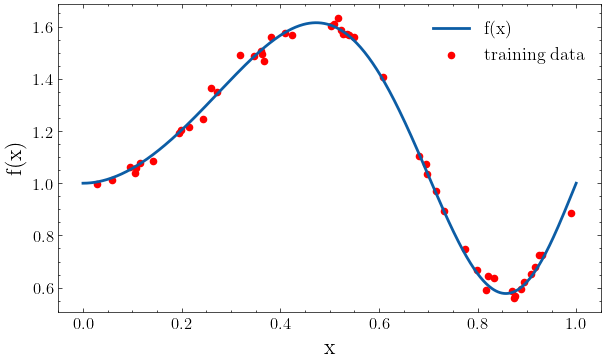

In [5]:
# Plot
fig, ax = plt.subplots(figsize=(7, 4))

line = ax.plot(x_points,y_noiseless,linewidth=2, label="f(x)")
scatter = ax.scatter(x_train,y_train, s=20, c="red", label="training data")

ax.set_xlabel("x", fontsize=16)
ax.set_ylabel("f(x)", fontsize=16)
# Add final legend
ax.legend(fontsize=13)

plt.savefig("img/basic_1dreg.pdf", dpi=300, format="pdf")
plt.show()

In [6]:
### Construct interval TEST data ###
x_lo,x_hi = interval_input(x_points, min_width=0.015, max_width=0.075)
x_int = np.stack([x_lo.T, x_hi.T], axis=1)
y_int = interval_propagation(x_int, noise=0.025)
y_int_noiseless = interval_propagation(x_int, noise=0)

100%|██████████| 500/500 [00:00<00:00, 39218.16it/s]


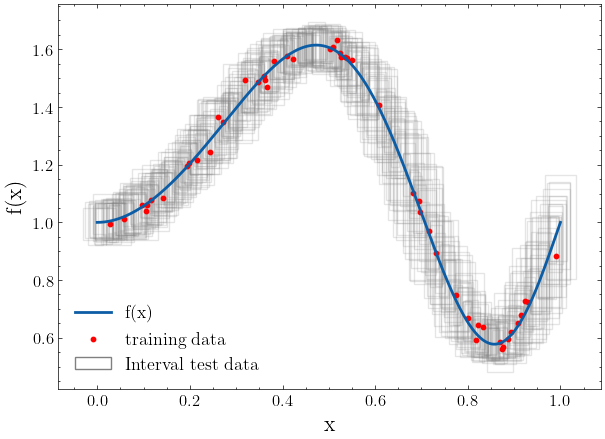

In [7]:
# Plot
fig, ax = plt.subplots(figsize=(7, 5))

for i in range(len(x_int)):
    x_lo, x_hi = x_int[i]
    y_lo, y_hi = y_int[i]
    width = x_hi - x_lo
    height = y_hi - y_lo
    rect = patches.Rectangle((x_lo, y_lo), width, height,
                             linewidth=1, edgecolor='grey', facecolor='none', alpha=0.2)
    ax.add_patch(rect)

rect_legend = patches.Patch(edgecolor='grey', facecolor='none', label='interval test')
line = ax.plot(x_points,y_noiseless,linewidth=2, label="f(x)")
scatter = ax.scatter(x_train,y_train, s=10, c="red", label="training data")

# Get existing handles and labels
handles, labels = ax.get_legend_handles_labels()

# Append custom rectangle legend
handles.append(rect_legend)
labels.append('Interval test data')

ax.set_xlabel("x", fontsize=16)
ax.set_ylabel("f(x)", fontsize=16)
# Add final legend
ax.legend(handles=handles, labels=labels, fontsize=13)

plt.savefig("img/aug_1dreg.pdf", dpi=300, format="pdf")
plt.show()

## Grid Augmentation

In [8]:
np.linspace(0.05,0.35,9)

array([0.05  , 0.0875, 0.125 , 0.1625, 0.2   , 0.2375, 0.275 , 0.3125,
       0.35  ])

In [9]:
grid_res = [[a] for a in np.linspace(0.05,0.35,9)]
x_train_int, y_train_int = ga.construct_interval_grid(x_train, y_train, 
                                                     grid_res=grid_res, n_shift=3, nmax_per_res=25)

100%|██████████| 9/9 [00:00<00:00, 700.72it/s]

Grid resolution [0.05] has 25 data
Grid resolution [0.0875] has 25 data
Grid resolution [0.125] has 24 data
Grid resolution [0.16249999999999998] has 19 data
Grid resolution [0.2] has 16 data
Grid resolution [0.2375] has 14 data
Grid resolution [0.27499999999999997] has 13 data
Grid resolution [0.3125] has 11 data
Grid resolution [0.35] has 10 data


In [10]:
x_train_int.shape

(157, 1, 2)

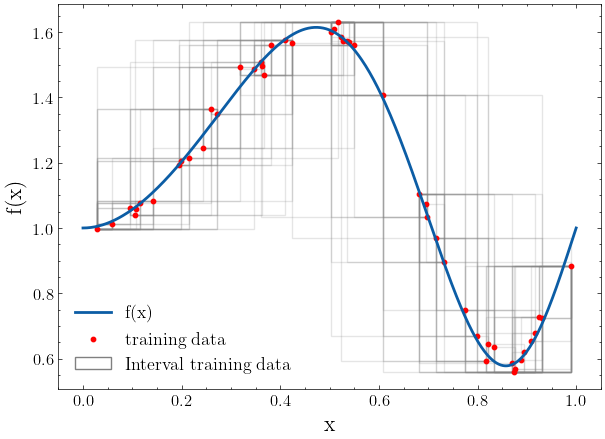

In [11]:
fig, ax = plt.subplots(figsize=(7, 5))

for i in range(len(x_train_int)):
    x_lo, x_hi = x_train_int[i,0]
    y_lo, y_hi = y_train_int[i,0]
    width = x_hi - x_lo
    height = y_hi - y_lo
    rect = patches.Rectangle((x_lo, y_lo), width, height,
                             linewidth=1, edgecolor='grey', facecolor='none', alpha=0.2)
    ax.add_patch(rect)

rect_legend = patches.Patch(edgecolor='grey', facecolor='none', label='interval test')
line = ax.plot(x_points,y_noiseless,linewidth=2, label="f(x)")
scatter = ax.scatter(x_train,y_train, s=10, c="red", label="training data")

# Get existing handles and labels
handles, labels = ax.get_legend_handles_labels()

# Append custom rectangle legend
handles.append(rect_legend)
labels.append('Interval training data')

ax.set_xlabel("x", fontsize=16)
ax.set_ylabel("f(x)", fontsize=16)
# Add final legend
ax.legend(handles=handles, labels=labels, fontsize=13)

plt.savefig("img/aug_1dreg_train.pdf", dpi=300, format="pdf")
plt.show()

## Naive IMLP

In [12]:
def naiveimlp(input_shape, hidden_layers=[32,64,32], output_size=2):
    """interval multilayer perceptron constructor

    Args:
        input_shape (_type_): _description_
        n_hidden_layers (int, optional): Number of hidden layers. Defaults to 1.
    """

    assert type(hidden_layers) == list , "Hidden layers should be a list."
    assert type(output_size) == int and output_size > 0, "Output size should be an integer and greater than 0"

    # Input layers
    inputs = keras.Input(input_shape)

    # MLP hidden layers
    for idx,n_layers in enumerate(hidden_layers):
        if idx == 0:
            x = layers.Dense(n_layers,activation="silu")(inputs)
        else:
            x = layers.Dense(n_layers,activation="silu")(x)
    
    # MLP output layers
    outputs = layers.Dense(output_size, activation=None)(x)

    model = keras.Model(inputs, outputs, name="NaiveIMLP")

    return model

In [13]:
def linex_loss(d,a):
    """Linear-exponential loss"""
    b = 2
    term1 = (tf.exp(-a*d)+(a*d)-1)
    return b*term1

def neg_distance_pen(dist):
     """Negative distance penalty"""
     return tf.where(dist < 0, (5*dist)**2, 0)

def custom_loss(target, y_pred, linex_a=5):
    err_lo = (target[...,0] - y_pred[...,0]) #preds better be lower than target
    err_hi = (y_pred[...,1] - target[...,1]) #target better be lower than preds
    term1 = linex_loss(err_lo, a=linex_a)
    term2 = linex_loss(err_hi, a=linex_a)
    dist = y_pred[...,1]-y_pred[...,0]
    loss = tf.reduce_mean(term1) + tf.reduce_mean(term2) + tf.reduce_mean(neg_distance_pen(dist))

    return loss

In [14]:
inn = naiveimlp(input_shape=2, hidden_layers=[16,16,16], output_size=2)

2025-12-03 14:28:08.077147: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-12-03 14:28:08.077177: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-03 14:28:08.077181: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-12-03 14:28:08.077526: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-03 14:28:08.078102: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
x_train_int = x_train_int.reshape(x_train_int.shape[0],2)
y_train_int = y_train_int.reshape(y_train_int.shape[0],2)

In [16]:
x_train_int.shape

(157, 2)

In [17]:
def run_experiment(model, x_int_train, y_int_train, x_int_test, y_int_test, 
                   repetitions=10, n_train = 50, epochs=1000, verbose=0):
    """Run the experiment with the given model and data."""
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=1e-2), loss=custom_loss)

    results = []

    # Choose n_train random as training data
    for seed in tqdm(range(repetitions)):
        data = dict()
        np.random.seed(seed)
        idx = np.random.choice(np.arange(x_int_train.shape[0]), size=n_train, replace=False)
        x_train_int = x_int_train[idx]
        y_train_int = y_int_train[idx]   

        # Train model
        history = model.fit(x=x_train_int, y=y_train_int, epochs=epochs, verbose=verbose)

        # Evaluate model
        pred = model.predict(x_int_test)
        data["x_train"] = x_train_int
        data["y_train"] = y_train_int
        data["x_test"] = x_int_test
        data["y_test"] = y_int_test
        data["pred"] = pred
        data["history"] = history.history

        results.append(data)
        
    return results

In [18]:
results = run_experiment(inn, x_train_int, y_train_int, x_int, y_int, 
                         repetitions=10, n_train=50, epochs=1500, verbose=0)
joblib.dump(results, "output/simple1dreg_aug_naive_ntrain50.pkl")

  0%|          | 0/10 [00:00<?, ?it/s]

2025-12-03 14:28:08.719730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 3ms/step


 10%|█         | 1/10 [00:28<04:14, 28.25s/it]

16/16 [==============================] - 0s 2ms/step


 20%|██        | 2/10 [00:58<03:57, 29.70s/it]

16/16 [==============================] - 0s 2ms/step


 30%|███       | 3/10 [01:24<03:15, 27.94s/it]

16/16 [==============================] - 0s 2ms/step


 40%|████      | 4/10 [01:50<02:42, 27.13s/it]

16/16 [==============================] - 0s 2ms/step


 50%|█████     | 5/10 [02:17<02:14, 26.90s/it]

16/16 [==============================] - 0s 3ms/step


 60%|██████    | 6/10 [02:43<01:46, 26.71s/it]

16/16 [==============================] - 0s 3ms/step


 70%|███████   | 7/10 [03:10<01:20, 26.84s/it]

16/16 [==============================] - 0s 2ms/step


 80%|████████  | 8/10 [03:40<00:55, 27.77s/it]

16/16 [==============================] - 0s 2ms/step


 90%|█████████ | 9/10 [04:08<00:27, 27.72s/it]

16/16 [==============================] - 0s 2ms/step


100%|██████████| 10/10 [04:34<00:00, 27.42s/it]


['output/simple1dreg_aug_naive_ntrain50.pkl']

Inverted predicted interval count: 12/500


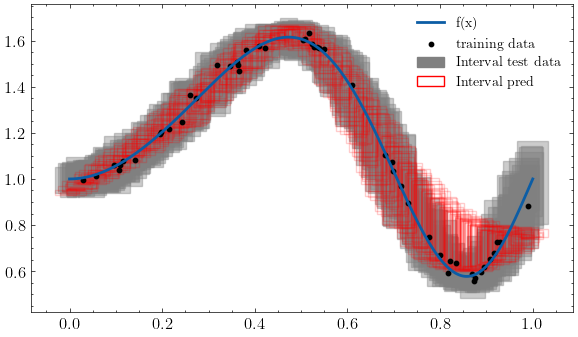

In [19]:
id = 0 # Experiment ID
fig, ax = plt.subplots(figsize=(7, 4))

data = results[id]
x_train_int = data["x_train"]
y_train_int = data["y_train"]
x_test_int = data["x_test"]
y_test_int = data["y_test"]
pred = data["pred"]
history = data["history"]

for i in range(len(x_int)):
    x_lo, x_hi = x_int[i]
    y_lo, y_hi = y_int[i]
    width = x_hi - x_lo
    height = y_hi - y_lo
    rect = patches.Rectangle((x_lo, y_lo), width, height,
                             linewidth=1, edgecolor='grey', facecolor='grey', alpha=0.4)
    ax.add_patch(rect)

inverted_count = 0
for i in range(len(x_int)):
    x_lo, x_hi = x_int[i]
    width = x_hi - x_lo
    height2 = pred[i,1] - pred[i,0]
    if height2 < 0:
        inverted_count += 1
    rect2 = patches.Rectangle((x_lo, pred[i,0]), width, height2,
                             linewidth=1, edgecolor='red', facecolor='none', alpha=0.2)
    ax.add_patch(rect2)

print(f"Inverted predicted interval count: {inverted_count}/{len(x_int)}")
rect_legend = patches.Patch(edgecolor='grey', facecolor='grey', label='interval test')
rect_legend2 = patches.Patch(edgecolor='red', facecolor='none', label='interval pred')
line = ax.plot(x_points,y_noiseless,linewidth=2, label="f(x)")
mid_x = (x_int[:,1] + x_int[:,0])/2
scatter = ax.scatter(x_train,y_train, s=10, c="black", label="training data")

# Get existing handles and labels
handles, labels = ax.get_legend_handles_labels()

# Append custom rectangle legend
handles.append(rect_legend)
handles.append(rect_legend2)
labels.append('Interval test data')
labels.append('Interval pred')

# Add final legend
ax.legend(handles=handles, labels=labels)

plt.show()

In [20]:
lo = []
hi = []
for res in results:
    pred = res["pred"]
    x_test_int = res["x_test"]
    y_test_int = res["y_test"]
    rmse_lo = np.sqrt(np.mean((pred[:,0] - y_test_int[:,0])**2))
    rmse_hi = np.sqrt(np.mean((pred[:,1] - y_test_int[:,1])**2))

    lo.append(rmse_lo)
    hi.append(rmse_hi)

# print RMSE values with 3 decimal places
print(f"RMSE lower: {np.round(np.mean(lo),3)} \u00B1 {np.round(np.std(lo),3)} \nRMSE upper: {np.round(np.mean(hi),3)} \u00B1 {np.round(np.std(hi),3 )}")

RMSE lower: 0.047 ± 0.007 
RMSE upper: 0.057 ± 0.014
